<a href="https://colab.research.google.com/github/GabrielleRab/SRMPmachine/blob/main/COMPAS_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Understanding Bias in AI Used in the Criminal Justice System


Adapted from a notebook created by [Trenton Chang](https://trentonchang.org) (ctrenton@umich.edu) and Daniela Ganelin (daniela.inspiritai@gmail.com), [Inspirit AI](https://www.inspiritai.com/)

*This notebook may be modified or reproduced only for non-commercial educational purposes; this notice must be retained.*

In this notebook, we'll examine the role of artificial intelligence (AI) systems in the criminal justice system. We'll:

- Learn about the COMPAS model used in the criminal justice system
- Use basic machine learning techniques in Python to train a risk assessment model on the COMPAS data
- Analyze our model for bias - and discuss techniques for fighting it!


## Background: What is COMPAS?

**[COMPAS](https://en.wikipedia.org/wiki/COMPAS_(software)) is a risk-assessment tool that predicts whether a defendant is likely to commit another offense (*redicidivate*).** It's designed to be used in the [_pre-trial detention phase_](https://en.wikipedia.org/wiki/Remand_(detention)): this is when a judge decides whether someone who's been arrested will stay in jail until their trial or be releaed on bail. Software like COMPAS [is used in many parts of the U.S.](https://dl.acm.org/doi/pdf/10.1145/3022181).

**Discuss: What's your gut reaction about a tool like this?** Do you think an algorithm would help or hurt a judge in making fair decisions that protect both public safety and defendants' rights?

We'll use data from Broward County, Florida obtained by [ProPublica's audit of COMPAS](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). Alarmingly, **ProPublica found that COMPAS risk scores are systematically worse for Black defendants.** Opponents of COMPAS see it as a continuation of systemic anti-Blackness in the U.S. justice system; supporters argue this system might be more accurate and less biased than human judges.

Today, we'll be building our own risk assessment models, so that we can see where bias might come from - and whether we can fight it. We'll be discussing difficult and sensitive material, so please be mindful of how your words affect other people!


## Data Exploration

Let's start by exploring the Broward County dataset!

In [ ]:
#@title IMPORTANT: Run this cell to set up our tools and data!

%load_ext google.colab.data_table
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score

sns.set_theme(style="darkgrid")
np.set_printoptions(edgeitems=10)

!wget -q https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
print ()

data = pd.read_csv("compas-scores-two-years.csv", header=0)
data = data.drop(labels=['id', 'name', 'first', 'last', 'compas_screening_date', 'dob', 'days_b_screening_arrest',
                         'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
                         'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc',
                         'r_jail_in', 'r_jail_out', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'decile_score.1',
                         'violent_recid', 'vr_charge_desc', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end',
                         'v_screening_date', 'event', 'type_of_assessment', 'v_type_of_assessment', 'screening_date',
                         'score_text', 'v_score_text', 'v_decile_score', 'decile_score', 'is_recid', 'is_violent_recid'], axis=1)
data.columns = ['sex', 'age', 'age_category', 'race', 'juveline_felony_count', 'juveline_misdemeanor_count', 'juveline_other_count',
              'prior_convictions', 'current_charge', 'charge_description', 'recidivated_next_two_years']
data['current_charge'] = data['current_charge'].replace({"F":"Felony","M":"Misdemeanor", "O":"Other"})
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix

def plot_errors(model,input_data, output_data, title='Confusion matrix'):
  pred = model.predict(input_data)
  cm = confusion_matrix(output_data, pred)
  sns.heatmap(cm, annot=True, cmap=plt.get_cmap('Blues'), fmt='d')
  plt.title(title)
  plt.ylabel("Actual")
  plt.xlabel("Predicted (model output)")
  plt.show()

print ("Tools and data loaded!")


Tools and data loaded!


The most important thing to start exploring this problem is to **visualize the data.** Let's print out the dataframe below! This is a selection of the Broward County data.

In [ ]:
#Click the button to the left to run this code!
data

**Discuss:**
- What kind of data do we have on the defendants?
- Do you notice any patterns?
- Is there anything surprising or confusing?
- Which of these columns are "fair" to consider in predicting whether someone will recidivate? Which are "unfair" or potentially harmful?

### Data Visualizations

Let's make some visualizations to make sense of our data, using a tool called [Seaborn](https://seaborn.pydata.org/generated/seaborn.countplot.html).



#### Visualizing Sex

To start with, **how many defendants do we have of each sex?** Run the code below to make a graph:

In [ ]:
graph = sns.countplot(x="sex", data=data)

**Discuss:** How would you intepret these results? Can you explain this pattern?



#### Visualizing Age Category

Now, try plotting **the number of defendants in each age category** by adapting the code above.

In [ ]:
graph = sns.countplot(x="age_category", data=data)

Any interesting patterns here?

Next, let's plot the **number of defendants of each race:**

#### Visualizing Race

Now, try plotting **the number of defendants in each age category** by adapting the code above.

In [ ]:
graph = sns.countplot(x="race", data=data)

#makes formatting nicer!
_ = graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

**What do you notice here?** Why might it be hard to learn how well our model works for Asian or Native American defendants?


#### Visualizing Recidivism


Finally, let's make a graph for a particularly important column: **"recidivated_next_two_years". This column shows whether the defendant was arrested again in the next two years** after the current arrest.
It's what our risk assessment model is trying to predict!

"0" means "No, did not recidivate", and "1" means "Yes, did recidivate."


In [ ]:
graph = sns.countplot(x="recidivated_next_two_years", data=data)

#makes formatting nicer!
_ = graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

Does the pattern here surprise you?

You're welcome to keep exploring the data on your own! [Pandas](https://towardsdatascience.com/data-exploration-101-with-pandas-e059d0661313) and [Seaborn](https://seaborn.pydata.org/) are two useful tools.

## Training a Machine Learning Model

Now, let's train a machine learning model using our data!

Using machine learning, we'll train a model to predict recidivism.

Our model's **input** will be information about defendants' backgrounds.

Our model's **output** will be a prediction of whether they **will** (1) or **won't** (0) recidivate.

**We'll go through the following steps:**
1. Prepare our data by turning it into numbers, then splitting it into **training** and **testing** data
2. Set up a model called *logistic regression*
3. Train a logistic regression model on the **training** data
4. Evaluate our model, or see how well it does, on the **testing** data

Let's give it a go!

### Step 1: Prepare our Data

There are a few things we'll need to do to prepare our data for machine learning!

Computers "see" the world in terms of numbers, so we'll need to represent our data that way as well. Let's make that conversion:

In [ ]:
#@title Run this to represent our data numerically!
data_num = data.copy()
value_counts = data_num['charge_description'].value_counts()
data_num = data_num[data_num['charge_description'].isin(value_counts[value_counts >= 70].index)].reset_index(drop=True) # drop rare charges
for colname in data_num.select_dtypes(include='object').columns: # use get_dummies repeatedly one-hot encode categorical columns
  one_hot = pd.get_dummies(data_num[colname])
  data_num = data_num.drop(colname, axis=1)
  data_num = data_num.join(one_hot)
data_num = pd.concat((data_num,data_num.pop("recidivated_next_two_years")),axis=1)
data_num.head()

**Discuss:** What's changed? What does a 0 or 1 represent here? Did every possible charge get its own column?

We also need to select out `input_data` and `output_data`.

First, let's choose our `output_data` - We want to look at recidivism

In [ ]:
output_data = data_num[["recidivated_next_two_years"]] #FILL ME IN

output_data

For our `input_data`, we'll use **all the other columns**. Here's the full list of columns:

In [ ]:
data_num.columns

Based on the above, we will fill in the columns to use as inputs.

In [ ]:
input_data = data_num[['age', 'juveline_felony_count', 'juveline_misdemeanor_count',
       'juveline_other_count', 'prior_convictions', 'Female', 'Male',
       '25 - 45', 'Greater than 45', 'Less than 25', 'African-American',
       'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other', 'Felony',
       'Misdemeanor', 'Battery', 'Burglary Conveyance Unoccup',
       'Burglary Unoccupied Dwelling', 'DUI Property Damage/Injury',
       'Driving Under The Influence', 'Driving While License Revoked',
       'Felony Battery (Dom Strang)', 'Felony Driving While Lic Suspd',
       'Grand Theft (Motor Vehicle)', 'Grand Theft in the 3rd Degree',
       'Pos Cannabis W/Intent Sel/Del', 'Poss3,4 Methylenedioxymethcath',
       'Possess Cannabis/20 Grams Or Less', 'Possession of Cannabis',
       'Possession of Cocaine', 'arrest case no charge']] #FILL ME IN

input_data

You should have 34 columns in `input_data`.

One final step: let's [divide](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) our data into **training data** that we'll use to train our model, and **testing data** that we'll use to test how well it works on real-world data.

Why do we do this? You can think of the **training data** as homework problems (`input_train`) and solutions (`output_train`): as we do more and more homework problems, we can better understand how to solve them. Then the **testing_ ata** is like a test to see whether we generalize our knowledge to solve new problems!

In [ ]:
# You don't need to understand the details of this code!
# Check out the link if you're curious.

input_train, input_test, output_train, output_test = train_test_split(input_data, output_data, test_size=0.3, random_state = 1)
output_train = output_train.to_numpy().ravel() #this is formatting
output_test = output_test.to_numpy().ravel() #this is formatting

Try printing any of them out if you're curious!

### Step 2: Set up our Model

Now, we need to set up the model (machine learning tool) we'll use.

We'll be using a common model called [**logistic regression**](https://machinelearningmastery.com/logistic-regression-for-machine-learning/), a type of model that uses numerical inputs to predict 0/1 outputs. You can think of this as answering a yes/no question: in this case, whether a person will recidivate. You can also explore many other machine learning [classification models here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)!

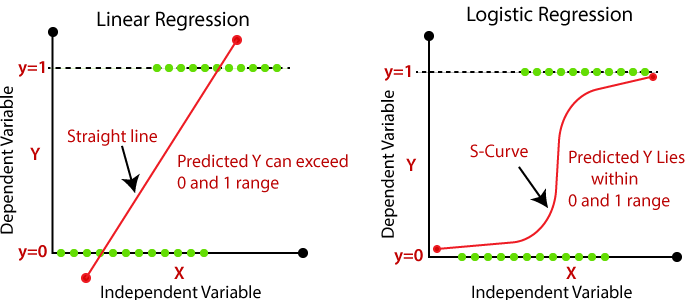

Run the code below to create the model.

In [ ]:
model = LogisticRegression(max_iter=1000)

### Step 3: Train our Model

Now, we'll need to feed our training data into the model and train (or `fit`) it!

We'll use `model.fit()` and fill in the `input_train` and `output_train` so our model can learn.

In [ ]:
_ = model.fit(input_train, output_train)

### Step 4: Evaluate our Model

Now, our model is trained to make predictions. Let's see how good our model's predictions are!


We'll use `model.predict` and fill in the `input_test`. **Discuss:** Why don't we need to plug in the output here?

In [ ]:
output_pred = model.predict(input_test)

output_pred

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, ..., 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])

For comparison, here are the true answers - this is what our model was trying to predict! How close are they?

In [ ]:
output_test

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, ..., 1, 1, 1, 0, 0, 0, 1, 1, 1, 0])

We can use `accuracy_score` to get our overall accuracy, or the **percent of predictions that are correct.** To do this, we'll compare the **true answers** (`output_test`) and **predicted answers** (`output_pred`). How'd we do?

In [ ]:
accuracy_score(output_test, output_pred)

0.675

What's your accuracy as a percent?

**Discuss:** Is that high enough to use in practice? Do you think this is better or worse than a human judge could do at predicting future recidivism?

## Evaluating Bias

Now we have a model, and we know its overall accuracy.

But is our model **biased**? Does it perform better for some racial groups than others?

Let's check it out!

### Comparing Accuracy
We're going to compare the African-American and Caucasian groups, because that's where we have enough data points to draw conclusions. (What are we missing by only focusing on those two groups?)

Let's see how accurate our model is for **only African-Americans** vs. **only Caucasians**. Is it about the same?

We'll do some fancy [indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html) to separate our test datasets:

In [ ]:
input_test_AA = input_test[input_test['African-American'] == 1]
output_test_AA = output_test[input_test['African-American'] == 1]

Let's find our **accuracy for only African-Americans**.

In [ ]:
output_pred_AA = model.predict(input_test_AA)
accuracy_score(output_pred_AA, output_test_AA)

0.6777456647398844

Now, let's find our **accuracy for only Caucasians!**

In [ ]:
input_test_C = input_test[input_test['Caucasian'] == 1]
output_test_C = output_test[input_test['Caucasian'] == 1]
output_pred_C = model.predict(input_test_C)
accuracy_score(output_pred_C, output_test_C)

0.656319290465632

**Discuss:** Does our model seem biased, or does it perform about the same on both groups?

If it is biased, does the direction of the bias surprise you?

### Comparing Error Types

So far, it looks like our model performs about the same on both groups: modestly above random performance (around 65%).

Now, let's check out how our model fails when it gets it wrong. There are four possible situtations:
- Correct: predicting a person will recidivate when they will (True Positive)
- Correct: predicting a person won't recidvate when they won't (True Negative)
- Mistake: incorrectly predicting that a person will recidivate when they actually won't (False Positive)
- Mistake: incorrectly predicting a person won't recidivate when they will (False Negative)

**Discuss:** What are the consequences of each kind of mistake? Which one do you think is worse, and why?

Let's check out how often our model makes each kind of mistake!


Let's start with **African Americans**. Here's the breakdown of our model's results:

**Check your understanding:** Which cell in the confusion matrix corresponds to a false positive? What about a false negative? Can you find where the true positives and true negatives are as well?

**Discuss:** How many people are in each category? Does the model make one kind of mistake more than the other, or is it about equal?

In [ ]:
plot_errors(model, input_test_AA, output_test_AA)

Now, let's try the same thing with **Caucasians!**

In [ ]:
plot_errors(model, input_test_C, output_test_C)

**Discuss:** For Caucasians, how often does the model make two kinds of mistakes? Is the model "more forgiving" or "less forgiving" for Caucasians compared to African-Americans? Is it biased?

# (Challenge) Fighting Bias

Whoa - our model is biased! Although it has about the same accuracy for both groups, a closer inspection showed that it's much more forgiving for White than Black defendants.

**Discuss:** How could this be? How could we fix it?

### Removing Race

Maybe the problem is that we used race as an input to our model! Does that seem right?

Let's **try removing race from the model.** We'll take the same train and test splits that we worked with, and drop all features corresponding to race.

Let's start by **removing the race columns.**

**Hint:** Look at the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) of the `drop` function to see how to drop columns from a DataFrame!

In [ ]:
race_column_names = ["African-American", "Asian", "Caucasian", "Hispanic", "Native American", "Other"]

input_train_no_race = input_train.drop(race_column_names, axis='columns') #remove race columns
input_test_no_race = input_test.drop(race_column_names, axis='columns') #remove race columns


Now, we've filled in a cell to retrain a new logistic regression model on this new data! This will print out the accuracies for each group (Black and White) as well as the confusion matrices. All the code is similar to what we've done before!

**Discuss:** What do we see in the results? Is this better or worse than the original model, which included racial information?


In [ ]:
# Fit a logistic regression model to the new data and report accuracy
no_race_model = LogisticRegression(max_iter=1000)
no_race_model.fit(input_train_no_race, output_train)
preds = no_race_model.predict(input_test_no_race)
print("Overall accuracy:", accuracy_score(output_test, preds))

# Split up the inputs of the new data by race
input_test_AA_no_race = input_test_no_race[input_test['African-American'] == 1]
input_test_C_no_race = input_test_no_race[input_test['Caucasian'] == 1]

# Split up the predictions generated on the new data by race
preds_AA_no_race = preds[input_test['African-American'] == 1]
preds_C_no_race = preds[input_test['Caucasian'] == 1]

# Report accuracy by group
print("Accuracy, African-American group", accuracy_score(output_test_AA, preds_AA_no_race))
print("Accuracy, Caucasian group", accuracy_score(output_test_C, preds_C_no_race))
print()

# Plot confusion matrices
plot_errors(no_race_model, input_test_AA_no_race, output_test_AA, title="Confusion matrix, Black defendants")
plot_errors(no_race_model, input_test_C_no_race, output_test_C, title="Confusion matrix, White defendants")

### Other Approaches

It turns out that removing race does not remove racial bias! How could this be?

One possible explanation is that racial bias can be **baked into the data.**

For example, Black adults are [much more likely](https://www.aclu.org/gallery/marijuana-arrests-numbers) than White adults to be arrested for marijuana use despite approximately equal usage rates. This means that if someone's arrested for marijuana, they're probably Black - so if a model pays attention to marijuana arrests, it may develop a racial bias!

So how do we actually fight AI bias? It's an open research area, so this is where you come in!

Let's put on our scientific method hats for a second! Come up with a hypothesis for making your model more fair, and test it out. As a starting point, here's some ideas to ponder. We'll recommend a simple choice:

* **Different modeling choices:** Pick a different model from the `scikit-learn` library! You can simply copy-paste your old `LogisticRegression` code, replacing `LogisticRegression` with whatever model you want to try. Here's some suggestions out of the box -- don't worry if you don't know all the details:

```
Ridge Regression: from sklearn.linear_model import Ridge
LASSO Regression: from sklearn.linear_model import Lasso
Elastic-Net Regression (combination of Ridge and LASSO): from sklearn.linear_model import ElasticNet
Support-Vector Classifiers: from sklearn.svm import SVC
K-Nearest Neighbor Classifier: from sklearn.neighbors import KNeighborsClassifier
Naive Bayes Classifier: from sklearn.naive_bayes import MultinomialNB
```

You're encouraged to look up what each one of these classifiers does, using the official `scikit-learn` documentation.

You can also find other methods [here](https://scikit-learn.org/stable/supervised_learning.html).

#### Optional: Advanced Methods for Algorithmic Fairness

As a bonus, feel free to consider these ideas as well! These are much more time-consuming, but can give you some interesting results.

* **"Garbage in, garbage out:"** if racial bias is inherently baked into this dataset, perhaps changing the model won't help. Can we use sampling to [stratify our sample](https://en.wikipedia.org/wiki/Stratified_sampling), so that we can fairly classify everyone?
* **Add more layers:** Deeper models have more representational power, and are able to learn more complex data distributions. Does this translate to a more fair model?
* **Decreasing the number of parameters:** Deeper models are a double-edged sword -- they're also known to overfit to spurious correlations in the data, which can exacerbate biases. In this case, does simplifying the model help fairness?
* **Group-wise thresholds:** Treating "like cases alike and unlike cases unlike" is a possible definition of justice. How do we choose good "thresholds" for each group?

Feel free to select one of these ideas to test, or come up with your own! For more inspiration, [feel free to look at the Wikipedia page on machine learning fairness.](https://en.wikipedia.org/wiki/Fairness_(machine_learning)) Some additional notes:
* You're encouraged to reuse code from above for preprocessing/training models.
* You're free to (and even _encouraged_ to) Google a tutorial for implementing a model -- the point is to learn how to analyze model fairness, not measure how well you can hack together a ML pipeline.

**It doesn't matter if your model doesn't have good accuracy or good fairness.** The point of this exercise is to do error analysis, not create a perfect model. This isn't an easy problem -- people spend their careers studying this issue!

#### Optional Guiding Questions: Towards a Fairer Model

To help you think about this problem, here's a few guiding questions to think about. No need to write anything down, this is to help you think!

* Why do you think our old model was unfair?
* Why do you think your proposed method might overcome these biases? There's no wrong answer -- you're just coming up with a reasonable hypothesis right now, and you can always refine it as you get more information.
* How do you plan on evaluating the fairness of the model? Is it the same setup as above?


# Conclusion

**Congratulations!** In this notebook, you've built a version of COMPAS and discovered bias in it through close inspection.

**What conclusions do you draw?**
- Would you recommend this model to a judge, even though it's biased, if it might be *less* biased than a human?
- In other situations, do you think AI in the criminal justice system is a good idea? Why or why not?
- Is is possible to create a truly unbiased dataset? Are synthetic datasets (data not from real people, but generated statistically) unbiased?

## Optional: Some Further Thoughts

Unlike other ML tasks, creating a fair ML system is a problem without a clear-cut solution. We hope this has made you stop and think about how AI is deployed in the real world, and the difficulty of developing "fair" AI systems.

It's easy to focus on accuracy and improving performance -- these are certainly important! However, thinking not just about _fairness_, but the broad impact they have on real peoples' lives is just as -- and sometimes even more -- important. In some cases, treating people fairly and improving your model performance contradict one another! That's what makes thinking about AI fairness in the real world so difficult: there's multiple tradeoffs to consider.

With the increasing adoption of machine learning systems, we encourage you to think _beyond_ the mathematical fairness or performance of a model. For example:
* **Beyond Accuracy:** Even if a model is 100% accurate, who does that benefit? In your opinion, is the world a "better" place now?
* **Differing Definitions of Fairness:** We've given you _one_ definition of fairness to work with. Are there other ways we can define if a model is fair? If two definitions of fairness contradict one another -- how would you evaluate the model in that case?
* **Dataset Creation and Power Dynamics:** Where is the data coming from, and who's labeling the data? For this dataset, each individual 1) encountered the police, 2) was arrested, and lastly 3) a decision was made about the specific charge and its severity. Where might societal biases and inequalities seep into this process, if at all?
* **Fairness in the Wild:** When we deploy a machine learning model in the real world, how can we identify when the model is being "unfair," and how can we address these problems?
* **Limitataions of AI:** What problems do you think that AI inherently cannot or should not solve?

Lastly, we'll leave with an impactful quote:

> "All models are wrong. Some are useful. Most are anti-Black."

_-- [Devin Guillory](http://www.devinguillory.com/), PhD, Berkeley EECS; talk on [Combatting Anti-Blackness in the AI Community (The Ethics of AI in Context)](https://www.youtube.com/watch?v=2M3QSQ-N3pQ&ab_channel=CentreforEthics), Feb. 2021._




# Further Reading

## Technical

Angwin, Julia et. al. "Machine Bias," *ProPublica,* May 23, 2016, https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

Bolukbasi, Tolga, et al. "Man is to computer programmer as woman is to homemaker? debiasing word embeddings." arXiv preprint arXiv:1607.06520 (2016).

Buolamwini, Joy, and Timnit Gebru. "Gender shades: Intersectional accuracy disparities in commercial gender classification." Conference on fairness, accountability and transparency. PMLR, 2018.

Gebru, Timnit, et al. "Datasheets for datasets." arXiv preprint arXiv:1803.09010 (2018).

Mitchell, Margaret, et al. "Model cards for model reporting." Proceedings of the conference on fairness, accountability, and transparency. 2019.

## Non-technical

Alexander, Michelle. "The New Jim Crow: Mass Incarceration in the Age of Colorblindness," New York, NY: The New Press, 2010.

Barocas, Solon, and Andrew D. Selbst. "Big data's disparate impact." Calif. L. Rev. 104 (2016): 671.

Benjamin, Ruha. "Race after technology: Abolitionist tools for the new jim code." Social Forces (2019).

Broussard, Meredith. Artificial unintelligence: How computers misunderstand the world. MIT Press, 2018.

Christin, Angèle. “Algorithms in Practice: Comparing Web Journalism and Criminal Justice.” Big Data & Society, December 2017. doi:10.1177/2053951717718855.

Kaminski, Margot E., and Gianclaudio Malgieri. "Algorithmic impact assessments under the GDPR: producing multi-layered explanations." U of Colorado Law Legal Studies Research Paper 19-28 (2019).

O'Neil, Cathy. "Weapons of Math Destruction: How Big Data Increases Inequality and Threatens Democracy," Largo, MD: Crown Publishing Group, 2017.

## More Advanced Resources

* ACM FAccT Conference website: https://facctconference.org/
* Stanford CS335 (Fair, Accountable, and Transparent Machine Learning): https://hci.stanford.edu/courses/cs335/2020/sp/
* Stanford CS384 (Ethical and Social Issues in Natural Language Processing): https://web.stanford.edu/class/cs384/
* Fair Machine Learning Textbook: https://fairmlbook.org -- Ch. 2 dives deeper into COMPAS and mathematical fairness!